## Environment

* x=2, y=0 에서 출발하여 x=4, y=6에 도착하면 끝
* 벽 : (0,2), (1,2), (2,2) & (2,4), (3,4), (4,4)
* 보상은 스텝마다 -1 : 최단 거리로 G에 도달하는 것이 목적

In [33]:
class GridWorld():
    def __init__(self):
        self.x=2
        self.y=0

    def step(self,a):
        if a==0:
            self.move_left()
        elif a==1:
            self.move_up()
        elif a==2:
            self.move_right()
        elif a==3:
            self.move_down()
        reward = -1 # 보상은 항상 -1로 구정
        done = self.is_done()
        return (self.x,self.y),reward,done
    
    def move_left(self):
        if self.y==0:
            pass
        elif self.y==3 and self.x in [0,1,2]:
            pass
        elif self.y==5 and self.x in [2,3,4]:
            pass
        else:
            self.y-=1

    def move_right(self):
        if self.y==1 and self.x in [0,1,2]:
            pass
        elif self.y==3 and self.x in [2,3,4]:
            pass
        elif self.y==6:
            pass
        else:
            self.y+=1

    def move_up(self):
        if self.x==0:
            pass
        elif self.x==3 and self.y==2:
            pass
        else:
            self.x-=1

    def move_down(self):
        if self.x==4:
            pass
        elif self.x==1 and self.y==4:
            pass
        else:
            self.x+=1

    def is_done(self):
        if self.x==4 and self.y==6: # 목표 지점에 도달하면 끝
            return True
        else:
            return False
        
    def reset(self):
        self.x=2
        self.y=0
        return (self.x,self.y)

In [45]:
import random
import numpy as np
from utils.function_time import logging_time
from utils.visualization import action_visualize

# 방법1. MCControl

## Agent

In [46]:
class Agent():
    def __init__(self):
        self.q_table=np.zeros((5,7,4)) # q-value를 저장하는 변수, 모두 0으로 초기화 - 4개의 action 이기에 마지막 차원이 4
        self.eps=0.9 # epsilon : 랜덤 행동을 할 확률은 90%로 설정
        self.gamma=1.0
        self.alpha=0.01 # learning rate

    def select_action(self,s): # eps-greedy로 액션을 선택
        x,y=s
        coin=random.random()
        if coin<self.eps:
            action=random.randint(0,3)
        else:
            action_val=self.q_table[x,y,:]
            action=np.argmax(action_val) # 가장 큰 q-value를 갖는 action을 반환
        return action
    
    def update_table(self,history):
        # 한 에피소드에 해당하는 history를 입력으로 받아 q-table을 업데이트
        cum_reward=0
        for transition in history[::-1]:
            s,a,r,s_prime=transition
            x,y=s
            # 몬테카를로 방식
            self.q_table[x,y,a] = self.q_table[x,y,a]+self.alpha*(cum_reward-self.q_table[x,y,a])
            cum_reward= self.gamma*cum_reward+r
    
    def anneal_eps(self): # decaying eps-greedy
        self.eps-=0.03 # 선형적으로 줄어듬
        self.eps=max(self.eps,0.1)

    def show_table(self):
        # 학습이 끝난 후, 각 위치에서 어느 액션의 q-value가 가장 높은지 보여줌
        q_lst=self.q_table.tolist()
        data = np.zeros((5,7))
        for row_idx in range(len(q_lst)):
            row = q_lst[row_idx]
            for col_idx in range(len(row)):
                col = row[col_idx]
                action = np.argmax(col) # 가장 큰 q-value를 갖는 action을 반환
                data[row_idx,col_idx] = action
        return data

## 메인함수

In [47]:
def MC_main():
    env = GridWorld()
    agent = Agent()
    
    for n_epi in range(1000): # 에피소드만큼 학습
        done= False
        history= []
        
        s = env.reset()
        while not done: # 한 에피소드가 끝날 때까지
            a=agent.select_action(s)
            s_prime,r,done=env.step(a)
            history.append((s,a,r,s_prime))
            s=s_prime
        
        #한 에피소드가 끝나고 update_table 함수 호출
        agent.update_table(history) # 히스토리를 이용하여 에이전트 내 q-table을 업데이트
        agent.anneal_eps() # epsilon 값 조금씩 낮춤

        if n_epi%100==0:
            print("n_episode :{}, eps : {:.1f}%".format(n_epi, agent.eps*100))
            action_visualize(agent.show_table()) # 학습이 진행되는 과정을 시각화

    return agent.show_table() # 학습이 끝난 결과 출력

학습 결과는 매번 학습을 실행할 때마다 달라짐 -> 액션을 선택하는 과정에서 epsilon-greedy 라는 확률적 요소가 들어가 있기 때문

n_episode :0, eps : 87.0%


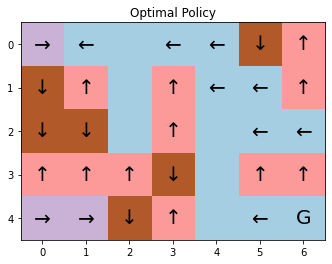

n_episode :100, eps : 10.0%


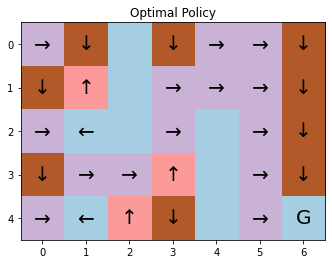

n_episode :200, eps : 10.0%


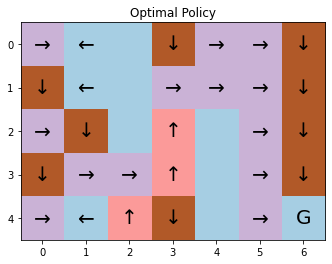

n_episode :300, eps : 10.0%


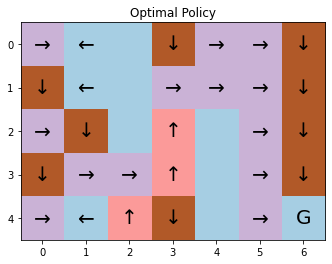

n_episode :400, eps : 10.0%


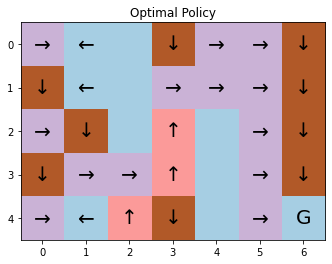

n_episode :500, eps : 10.0%


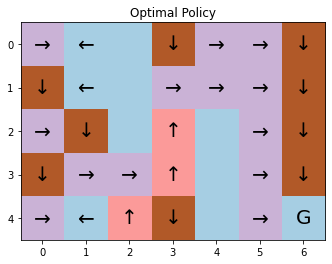

n_episode :600, eps : 10.0%


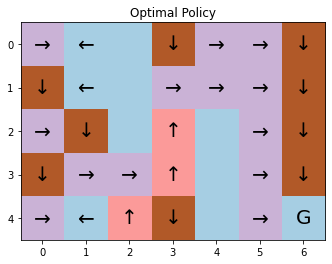

n_episode :700, eps : 10.0%


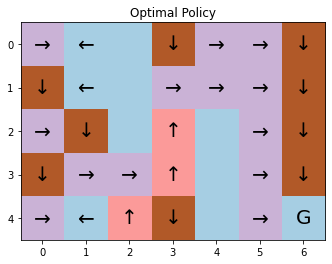

n_episode :800, eps : 10.0%


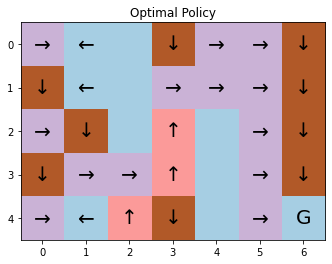

n_episode :900, eps : 10.0%


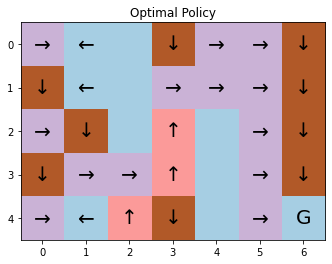

[[2. 0. 0. 3. 2. 2. 3.]
 [3. 0. 0. 2. 2. 2. 3.]
 [2. 3. 0. 1. 0. 2. 3.]
 [3. 2. 2. 1. 0. 2. 3.]
 [2. 0. 1. 3. 0. 2. 0.]]


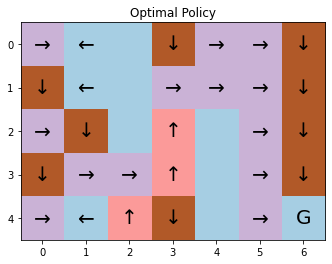

In [48]:
if __name__ == '__main__':
    MC_action = MC_main()
    print(MC_action)
    action_visualize(MC_action)

# 방법2. TD Control - SARSA

## Agent

In [49]:
class SAgent(Agent):
    def update_table(self, transition): # MC와 달리 transition을 인풋으로 받음
        s,a,r,s_prime=transition
        x,y=s
        next_x,next_y=s_prime
        a_prime=self.select_action(s_prime) # 다음 state에서 선택할 action (실제로 취한 액션이 아님)
        # SARSA 업데이트 식
        self.q_table[x,y,a]=self.q_table[x,y,a]+self.alpha*(r+self.q_table[next_x,next_y,a_prime]-self.q_table[x,y,a])

## 메인함수

In [50]:
@logging_time
def TD_main():
    env=GridWorld()
    agent=SAgent()
    
    for n_epi in range(5000):
        done=False
        s=env.reset()
        while not done:
            a=agent.select_action(s)
            s_prime,r,done=env.step(a)
            agent.update_table((s,a,r,s_prime)) # MC와 달리 한 스텝마다 업데이트
            s=s_prime
        agent.anneal_eps()

        if n_epi%1000==0:
            print("n_episode :{}, eps : {:.1f}%".format(n_epi, agent.eps*100))
            action_visualize(agent.show_table()) # 학습이 진행되는 과정을 시각화
            
    return agent.show_table()

n_episode :0, eps : 87.0%


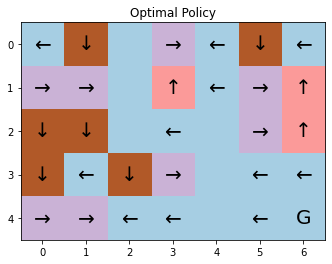

n_episode :1000, eps : 10.0%


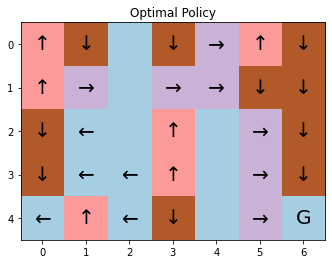

n_episode :2000, eps : 10.0%


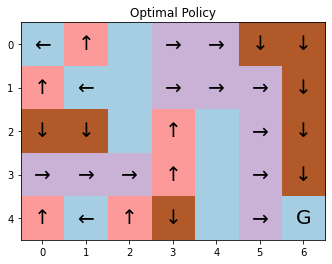

n_episode :3000, eps : 10.0%


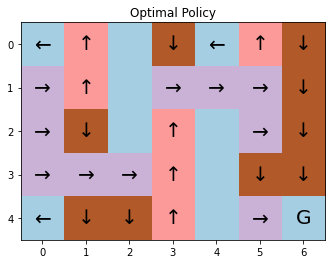

n_episode :4000, eps : 10.0%


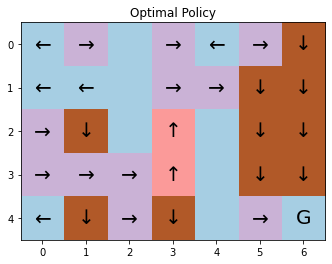

Running Time[TD_main]: 0.79054570 sec
[[0. 1. 0. 2. 3. 2. 3.]
 [1. 3. 0. 2. 2. 3. 3.]
 [2. 3. 0. 1. 0. 3. 3.]
 [2. 2. 2. 1. 0. 3. 3.]
 [0. 2. 1. 0. 0. 2. 0.]]


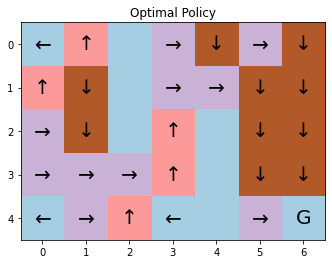

In [51]:
if __name__ == '__main__':
    S_action = TD_main()
    print(S_action)
    action_visualize(S_action)

결과분석
* 출발 지점에서 시작하여 화살표를 따라가면 도착 지점까지 최단 경로를 통해 도달 = 최적해
* 시작에서 종료까지 최적해를 따라가지만, 얼마나 탐색 (exploration) 했는가에 따라 경로 바깥의 칸들 (특히, 귀퉁이의 칸들) 의 최적 액션은 가끔 이상한 방향을 가리키기도 함.

# 방법3. TD Control - Q-Learning

## Agent

In [52]:
class QAgent(Agent):
    def update_table(self, transition):
        s,a,r,s_prime=transition
        x,y=s
        next_x,next_y=s_prime
        self.q_table[x,y,a]=self.q_table[x,y,a]+self.alpha*(r+np.amax(self.q_table[next_x,next_y,:])-self.q_table[x,y,a])
    
    def anneal_eps(self):
        self.eps-=0.01 # Q-learning은 eps를 전보다 천천히 줄어들도록 함
        self.eps=max(self.eps,0.2)

## 메인함수

In [53]:
@logging_time
def TD_main():
    env=GridWorld()
    agent=QAgent()
    
    for n_epi in range(5000):
        done=False
        s=env.reset()
        while not done:
            a=agent.select_action(s)
            s_prime,r,done=env.step(a)
            agent.update_table((s,a,r,s_prime))
            s=s_prime
        agent.anneal_eps()

        if n_epi%1000==0:
            print("n_episode :{}, eps : {:.1f}%".format(n_epi, agent.eps*100))
            action_visualize(agent.show_table()) # 학습이 진행되는 과정을 시각화
        
    return agent.show_table()

n_episode :0, eps : 89.0%


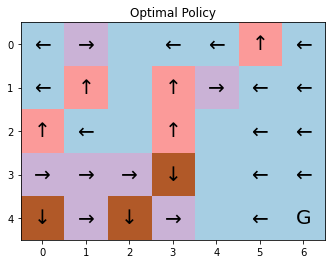

n_episode :1000, eps : 20.0%


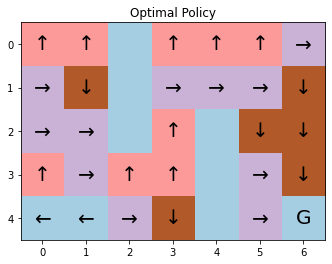

n_episode :2000, eps : 20.0%


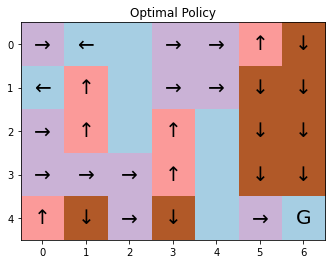

n_episode :3000, eps : 20.0%


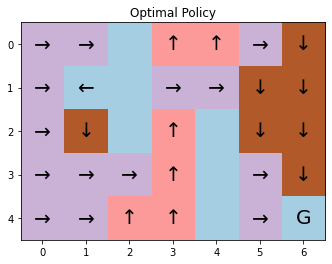

n_episode :4000, eps : 20.0%


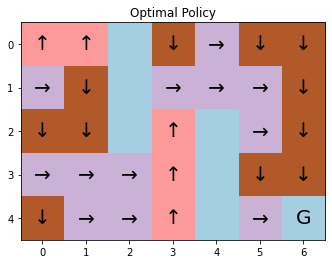

Running Time[TD_main]: 0.97490644 sec
[[0. 2. 0. 1. 2. 2. 3.]
 [2. 3. 0. 2. 2. 3. 3.]
 [3. 3. 0. 1. 0. 3. 3.]
 [2. 2. 2. 1. 0. 3. 3.]
 [0. 1. 2. 1. 0. 2. 0.]]


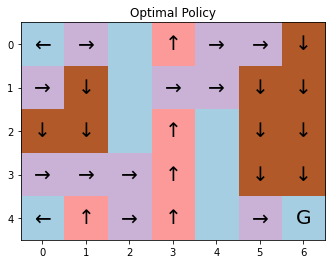

In [54]:
if __name__ == '__main__':
    Q_action = TD_main()
    print(Q_action)
    action_visualize(Q_action)